<a href="https://colab.research.google.com/github/mathengem/Algorithmic-Trading-Backtesting-in-python/blob/main/PricePrdictionandtrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install yahoo_fin

In [10]:
!pip install alpaca-trade-api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Successfully uninstalled msgpack-1.0.8


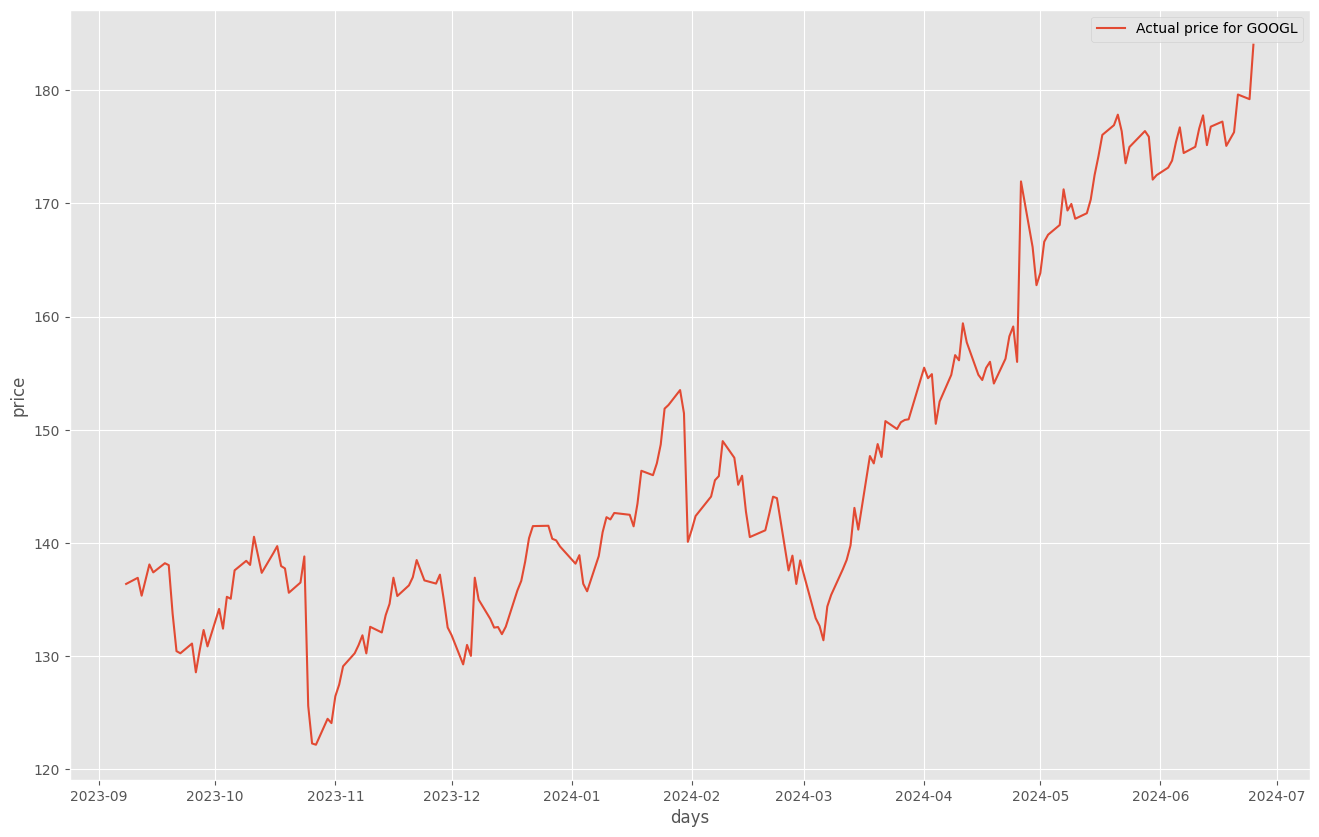

NameError: name 'GetTrainedModel' is not defined

In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

  def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model


  # GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))


  # Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

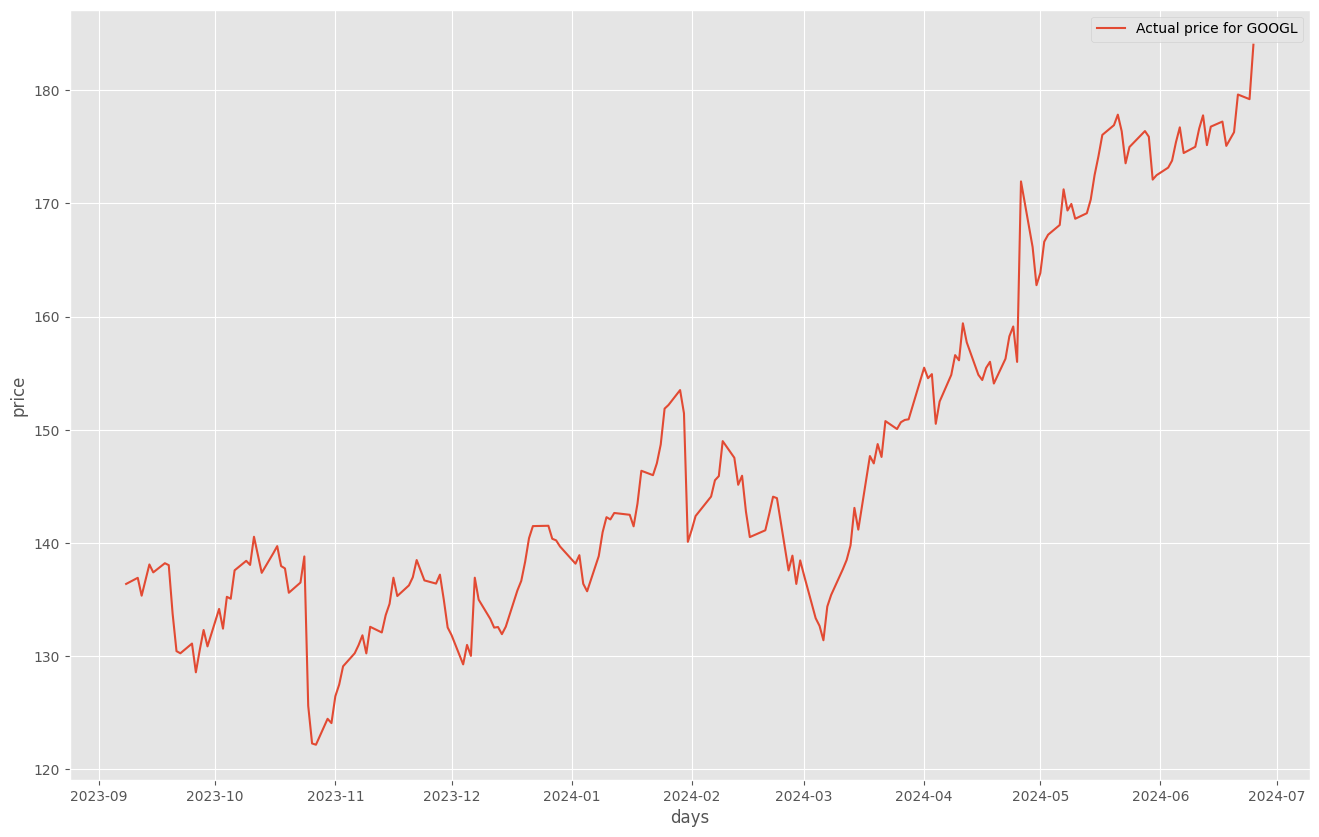

Epoch 1/80
94/94 [==============================] - 5s 9ms/step - loss: 0.0154
Epoch 2/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 3/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 4/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0031
Epoch 5/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 6/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 7/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0025
Epoch 8/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 9/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 10/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0024
Epoch 11/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0019
Epoch 12/80
94/94 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 13/80
94/94 [==============================

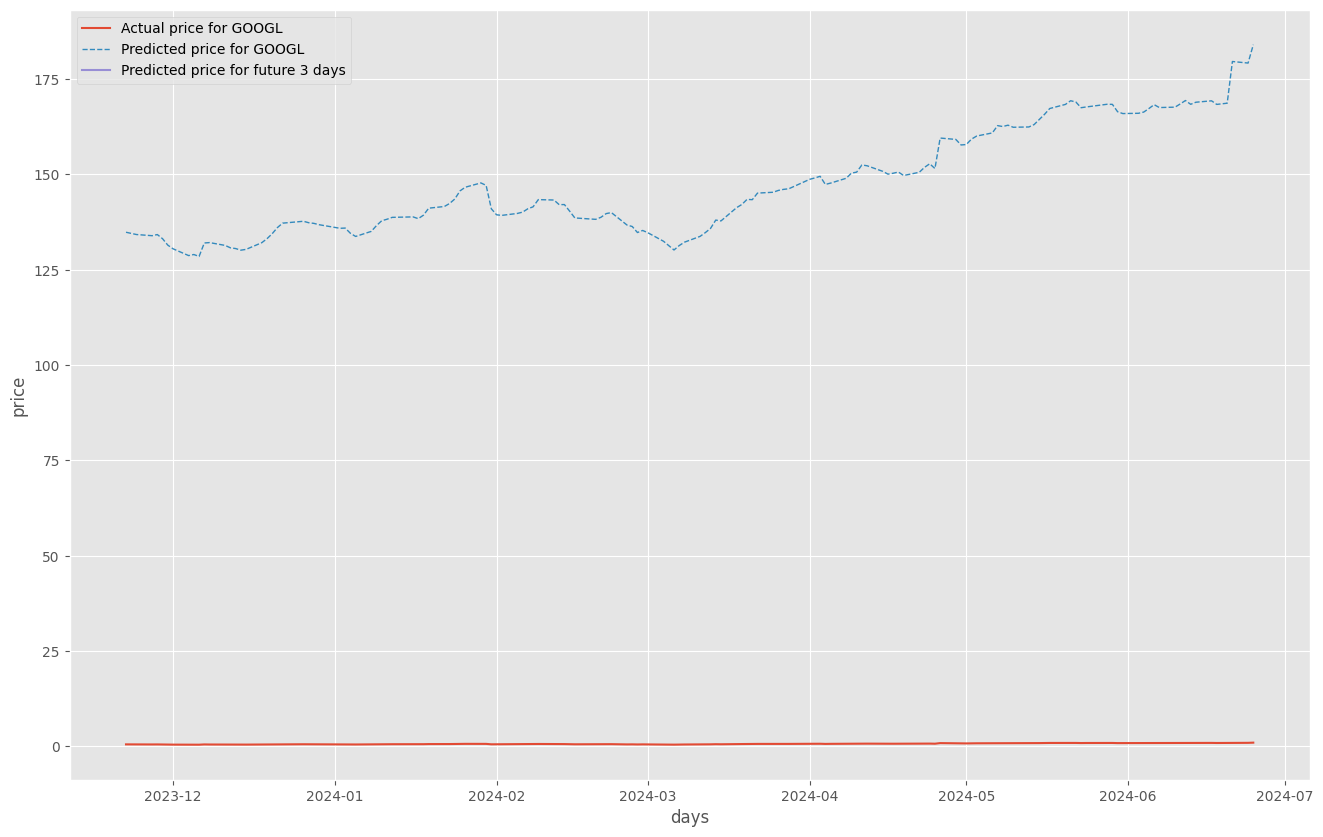

In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df['predicted_close'] = y_predicted_transformed

# Ensure the dataframe has the correct columns before adding new rows
copy_df = copy_df[['close', 'date', 'predicted_close']]

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# Add a placeholder for the actual closing price which is not available yet for future dates
copy_df.loc[date_now] = [np.nan, f'{date_now}', predictions[0]]
copy_df.loc[date_tomorrow] = [np.nan, f'{date_tomorrow}', predictions[1]]
copy_df.loc[date_after_tomorrow] = [np.nan, f'{date_after_tomorrow}', predictions[2]]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()


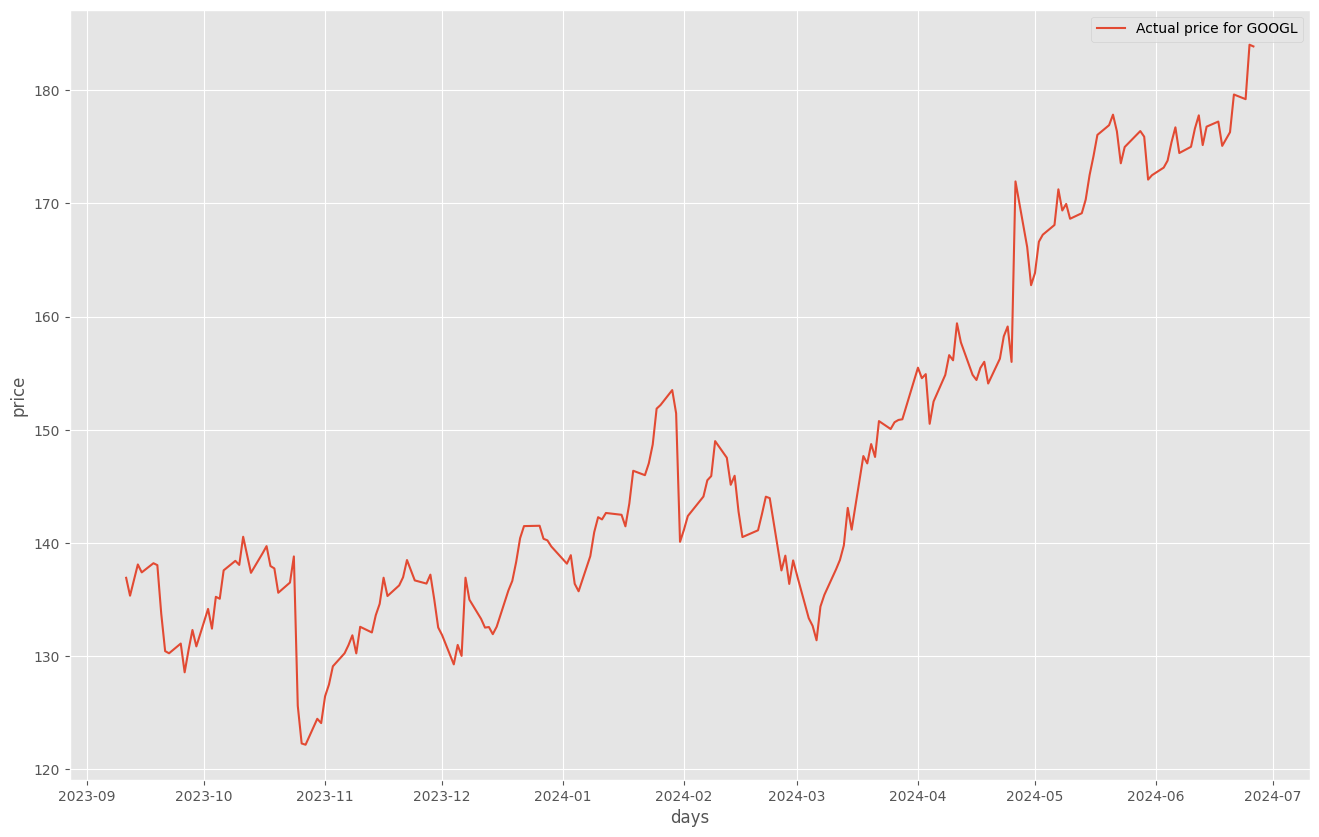

Epoch 1/80
94/94 [==============================] - 4s 9ms/step - loss: 0.0138
Epoch 2/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0036
Epoch 3/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 4/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 5/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 6/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 7/80
94/94 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 8/80
94/94 [==============================] - 1s 13ms/step - loss: 0.0027
Epoch 9/80
94/94 [==============================] - 1s 13ms/step - loss: 0.0023
Epoch 10/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 11/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0021
Epoch 12/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 13/80
94/94 [===========================

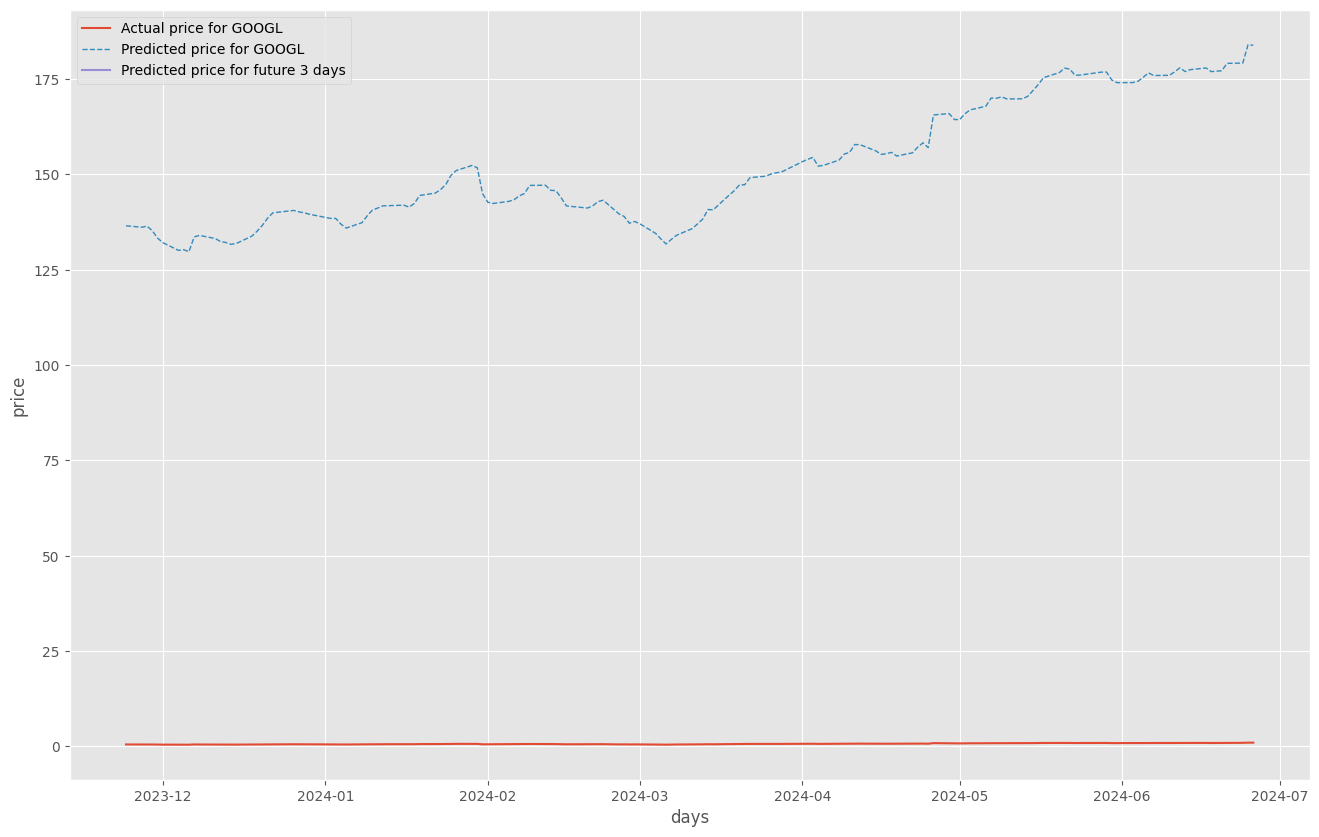

GOOGL prediction for upcoming 3 days: (181.66$, 181.35$, 184.02$)


In [9]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df['predicted_close'] = y_predicted_transformed

# Ensure the dataframe has the correct columns before adding new rows
copy_df = copy_df[['close', 'date', 'predicted_close']]

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# Add a placeholder for the actual closing price which is not available yet for future dates
copy_df.loc[date_now] = [np.nan, f'{date_now}', predictions[0]]
copy_df.loc[date_tomorrow] = [np.nan, f'{date_tomorrow}', predictions[1]]
copy_df.loc[date_after_tomorrow] = [np.nan, f'{date_after_tomorrow}', predictions[2]]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

# Print predictions
print(f"{STOCK} prediction for upcoming 3 days: ({predictions[0]}$, {predictions[1]}$, {predictions[2]}$)")


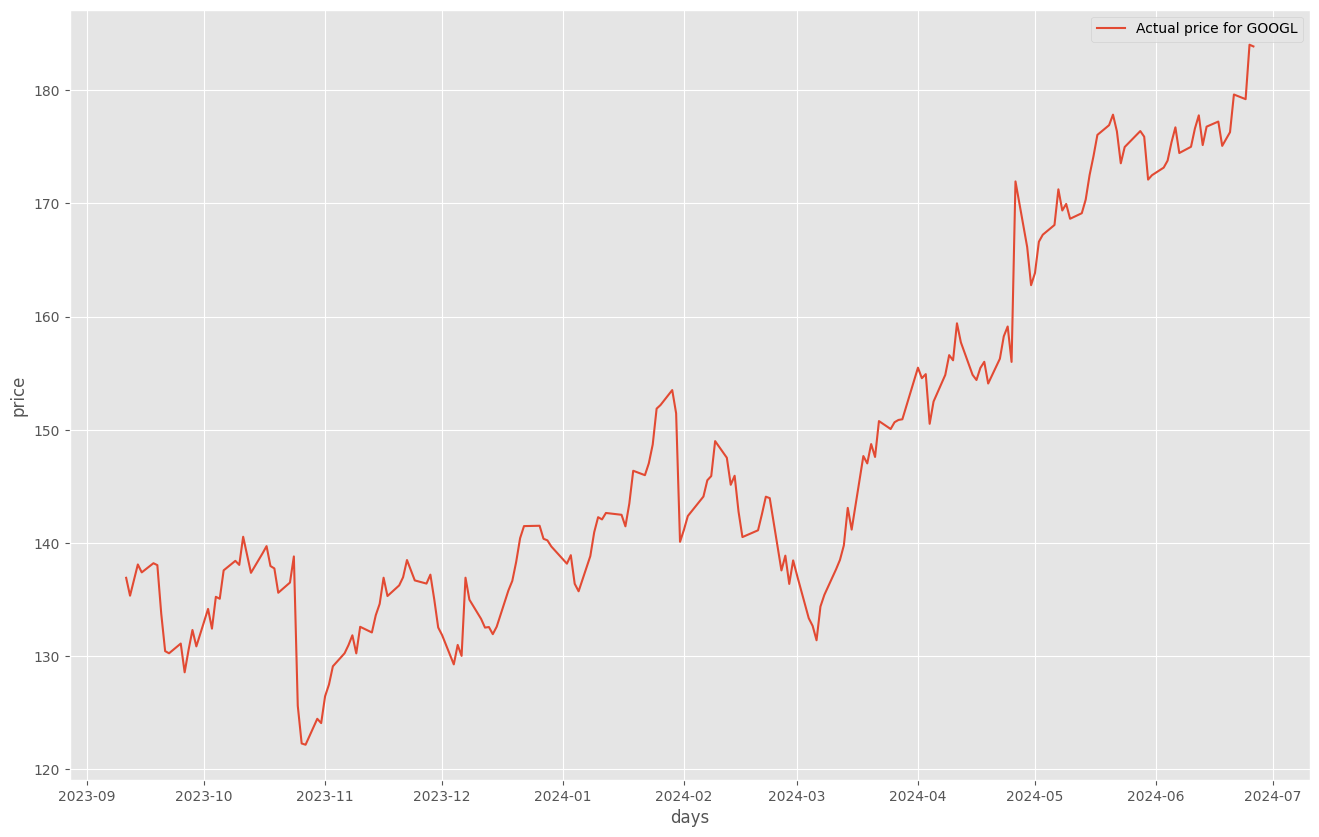

Epoch 1/80
94/94 [==============================] - 5s 9ms/step - loss: 0.0138
Epoch 2/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 3/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0038
Epoch 4/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0031
Epoch 5/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 6/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 7/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0027
Epoch 8/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0025
Epoch 9/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 10/80
94/94 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 11/80
94/94 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 12/80
94/94 [==============================] - 1s 16ms/step - loss: 0.0020
Epoch 13/80
94/94 [===========================

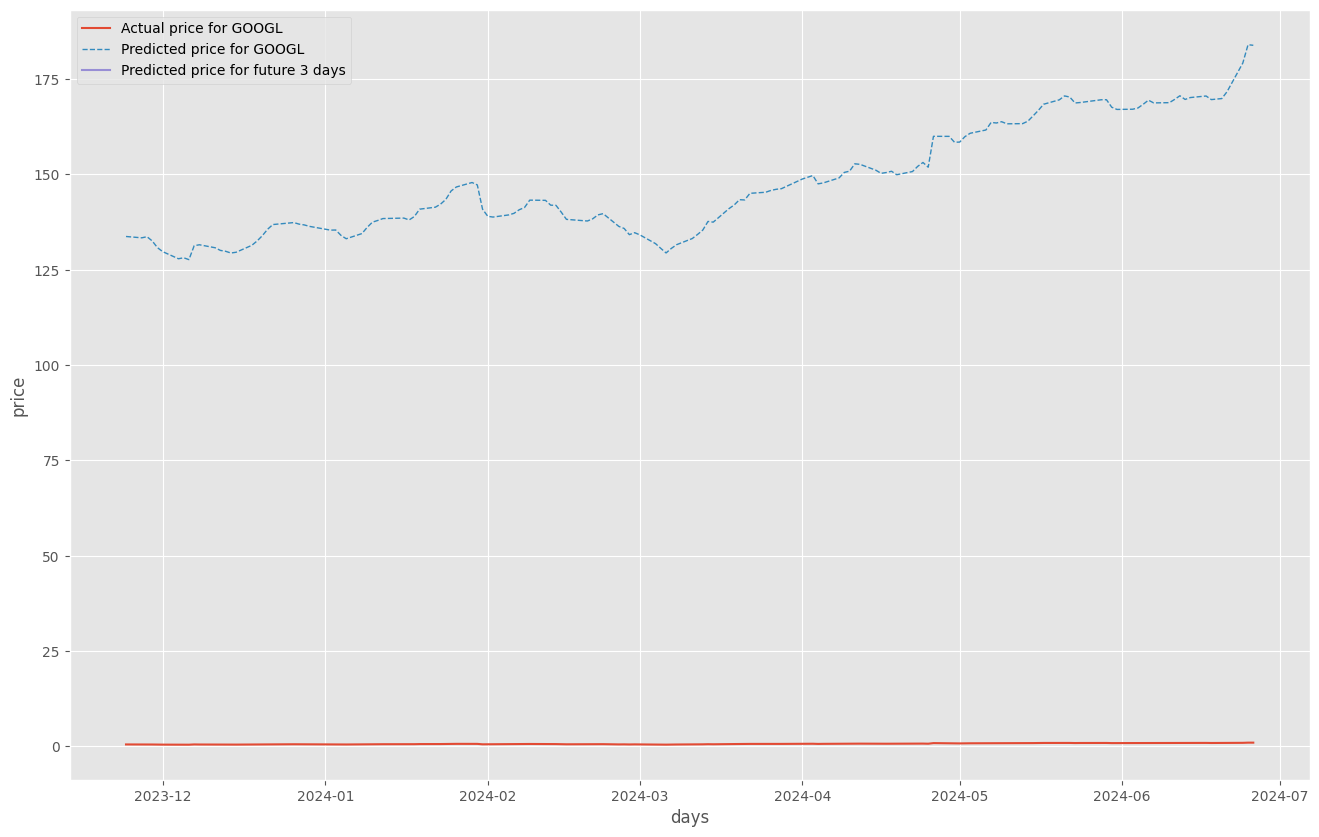

GOOGL prediction for upcoming 3 days: (180.48$, 181.77$, 176.1$)
Current price of GOOGL: 183.8800048828125$
An error occurred while placing the trade: invalid take_profit.limit_price 187.55760498046877. sub-penny increment does not fulfill minimum pricing criteria


In [11]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Trading
import alpaca_trade_api as tradeapi

# Graphics library
import matplotlib.pyplot as plt

# Alpaca API credentials
API_KEY = 'PKZUWPDI2JUJROBPDTO1'
API_SECRET = 'QK3v9j6eRinlRixWbmzKFZns7MeWm4mcS4UU23Vx'
BASE_URL = 'https://paper-api.alpaca.markets'

api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df['predicted_close'] = y_predicted_transformed

# Ensure the dataframe has the correct columns before adding new rows
copy_df = copy_df[['close', 'date', 'predicted_close']]

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# Add a placeholder for the actual closing price which is not available yet for future dates
copy_df.loc[date_now] = [np.nan, f'{date_now}', predictions[0]]
copy_df.loc[date_tomorrow] = [np.nan, f'{date_tomorrow}', predictions[1]]
copy_df.loc[date_after_tomorrow] = [np.nan, f'{date_after_tomorrow}', predictions[2]]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

# Print predictions
print(f"{STOCK} prediction for upcoming 3 days: ({predictions[0]}$, {predictions[1]}$, {predictions[2]}$)")

# Get the current price of the stock
current_price = yf.get_live_price(STOCK)
print(f"Current price of {STOCK}: {current_price}$")

# Set take profit level and pips for maximum profit based on account balance
# Assume a simple take profit strategy (e.g., 2% increase)
take_profit_percentage = 0.02
take_profit_price = current_price * (1 + take_profit_percentage)

# Assume 100 shares for the trade
quantity = 100

# Place a trade using Alpaca API
try:
    order = api.submit_order(
        symbol=STOCK,
        qty=quantity,
        side='buy',
        type='market',
        time_in_force='gtc',
        order_class='oto',
        take_profit=dict(
            limit_price=take_profit_price
        )
    )
    print(f"Trade placed: Buy {quantity} shares of {STOCK} at market price with take profit at {take_profit_price}$")
except Exception as e:
    print(f"An error occurred while placing the trade: {e}")


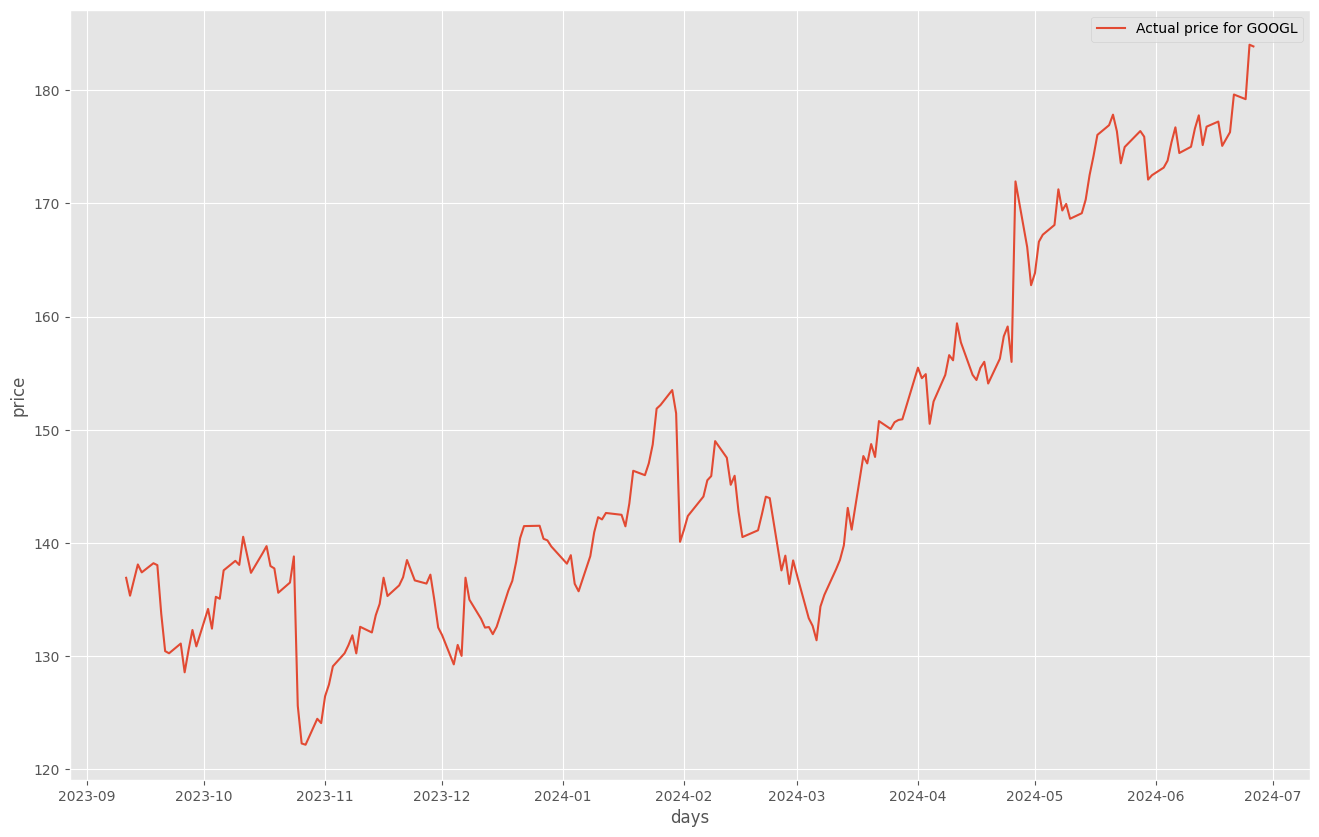

Epoch 1/80
94/94 [==============================] - 5s 10ms/step - loss: 0.0146
Epoch 2/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 3/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0032
Epoch 4/80
94/94 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 5/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 6/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 7/80
94/94 [==============================] - 1s 15ms/step - loss: 0.0025
Epoch 8/80
94/94 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 9/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 10/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 11/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 12/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 13/80
94/94 [====================

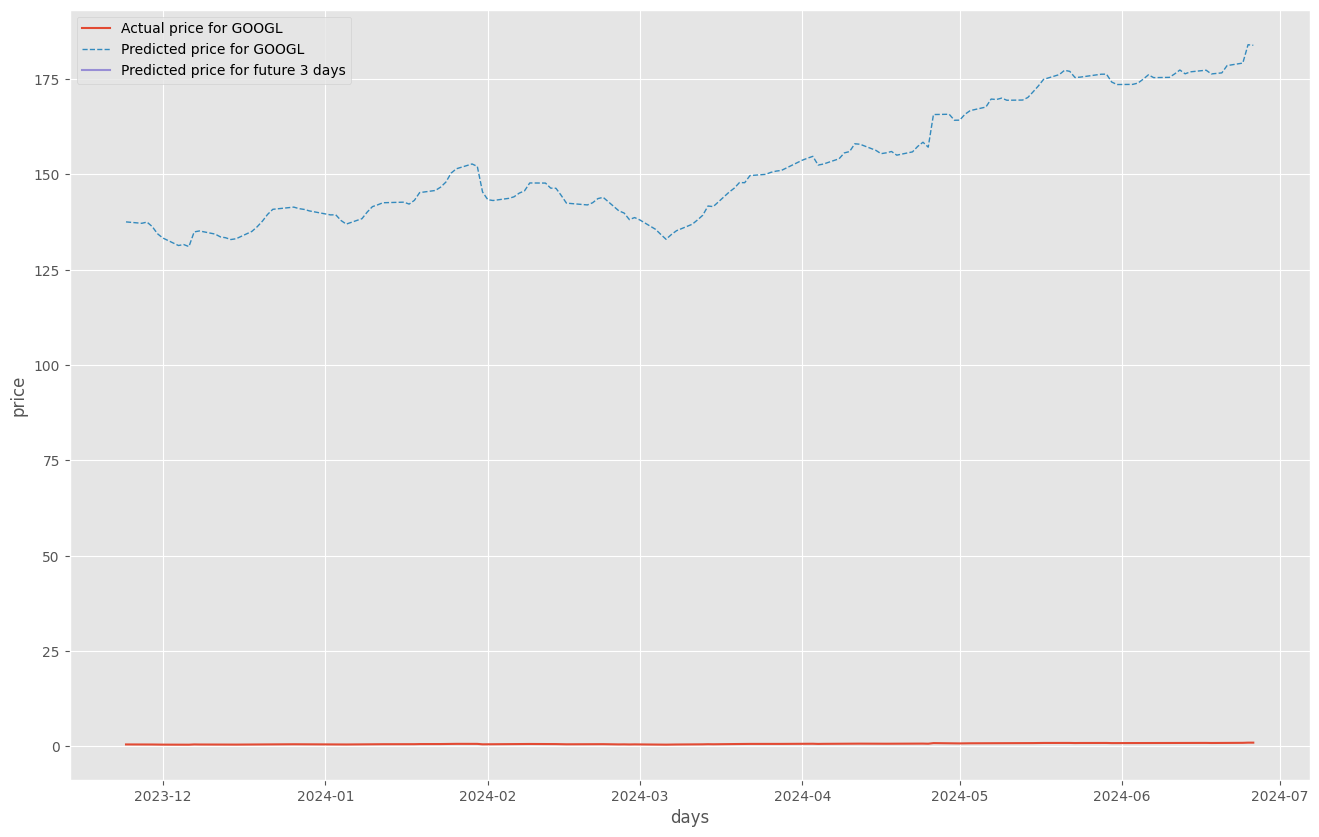

GOOGL prediction for upcoming 3 days: (180.18$, 184.4$, 183.26$)
Current price of GOOGL: 183.8800048828125$
Trade placed: Buy 100 shares of GOOGL at market price with take profit at 187.56$
Trade placed: Buy 100 shares of GOOGL at market price with take profit at 187.56$
Trade placed: Buy 100 shares of GOOGL at market price with take profit at 187.56$


In [12]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Trading
import alpaca_trade_api as tradeapi

# Graphics library
import matplotlib.pyplot as plt

# Alpaca API credentials
API_KEY = 'PKZUWPDI2JUJROBPDTO1'
API_SECRET = 'QK3v9j6eRinlRixWbmzKFZns7MeWm4mcS4UU23Vx'
BASE_URL = 'https://paper-api.alpaca.markets'

api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['close'].shift(-days)
    last_sequence = np.array(df[['close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

def GetTrainedModel(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 80

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    model.summary()

    return model

# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = PrepareData(step)
    x_train = x_train[:, :, :len(['close'])].astype(np.float32)

    model = GetTrainedModel(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df['predicted_close'] = y_predicted_transformed

# Ensure the dataframe has the correct columns before adding new rows
copy_df = copy_df[['close', 'date', 'predicted_close']]

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# Add a placeholder for the actual closing price which is not available yet for future dates
copy_df.loc[date_now] = [np.nan, f'{date_now}', predictions[0]]
copy_df.loc[date_tomorrow] = [np.nan, f'{date_tomorrow}', predictions[1]]
copy_df.loc[date_after_tomorrow] = [np.nan, f'{date_after_tomorrow}', predictions[2]]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

# Print predictions
print(f"{STOCK} prediction for upcoming 3 days: ({predictions[0]}$, {predictions[1]}$, {predictions[2]}$)")

# Get the current price of the stock
current_price = yf.get_live_price(STOCK)
print(f"Current price of {STOCK}: {current_price}$")

# Set take profit level and pips for maximum profit based on account balance
# Assume a simple take profit strategy for each prediction
take_profit_percentages = [0.02, 0.02, 0.02]
quantities = [100, 100, 100]  # Assume 100 shares for each trade

for i, prediction in enumerate(predictions):
    take_profit_price = current_price * (1 + take_profit_percentages[i])
    take_profit_price = round(take_profit_price, 2)  # Ensure price is rounded to two decimal places

    try:
        order = api.submit_order(
            symbol=STOCK,
            qty=quantities[i],
            side='buy',
            type='market',
            time_in_force='gtc',
            order_class='oto',
            take_profit=dict(
                limit_price=take_profit_price
            )
        )
        print(f"Trade placed: Buy {quantities[i]} shares of {STOCK} at market price with take profit at {take_profit_price}$")
    except Exception as e:
        print(f"An error occurred while placing the trade for day {i + 1}: {e}")
